### Github地址:https://github.com/Evolte-ZGQ/Data_Mining_2

# Facebook数据挖掘
## 数据获取与数据预处理
### 数据获取
- 从官网下载Facebook数据集。下载后打开该数据集。



In [5]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx
from random import randint

# 获取数据
data = pd.read_csv(
    "facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)

- 建立网络，实现可视化并输出基本信息。

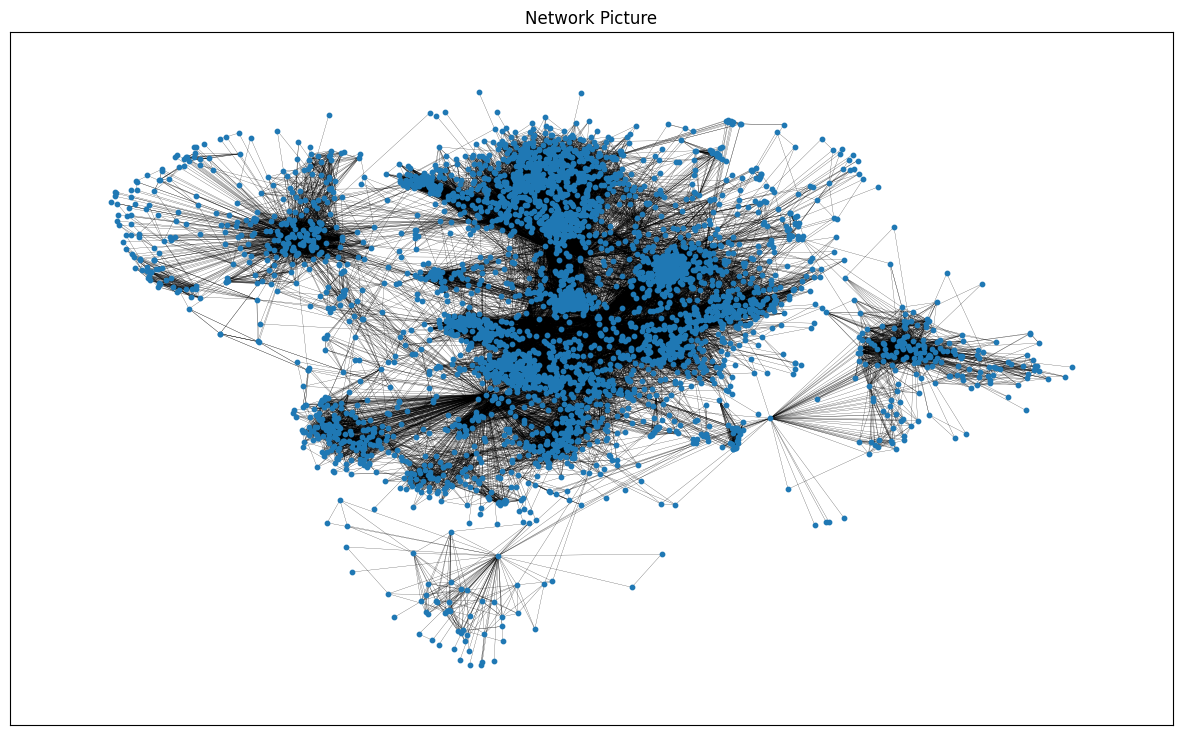

In [36]:
# 建立网络
network = nx.from_pandas_edgelist(data, "start_node", "end_node")
pos = nx.spring_layout(network, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
ax.set_title("Network Picture")
nx.draw_networkx(network, pos=pos, ax=ax, **plot_options)
plt.show()

In [7]:
Node_Num = network.number_of_nodes()
print("节点数量", Node_Num)
Edge_Num = network.number_of_edges()
print("边数量", Edge_Num)
Max_Path_Length = nx.diameter(network)
print("最大路径长度", Max_Path_Length)
Av_Path_Length = nx.average_shortest_path_length(network)
print("平均路径长度", Av_Path_Length)
Assortativity = nx.degree_assortativity_coefficient(network)
print("匹配性", Assortativity)

节点数量 4039
边数量 88234
最大路径长度 8
平均路径长度 3.6925068496963913
匹配性 0.06357722918564943


- 除上述txt文件外，数据集中还包含一个facebook文件夹，其中包含circles、edges、egofeat、feat、featnames五类文件。为简化操作，我们只使用circles文件，它包含着成环的用户id组合。

In [26]:
import tarfile
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import os
tar_gz_path = 'facebook.tar.gz'
# 解压文件
with tarfile.open(tar_gz_path, 'r:gz') as tar:
    tar.extractall()

In [29]:
# 读取一个圈子文件的内容
def read_circles(file_path):
    circles = []
    with open(file_path, 'r') as file:
        for line in file:
            circle = line.strip().split()[1:]
            if circle:
                circles.append(circle)
    return circles
# 遍历文件夹读取所有圈子文件
def read_all_circles(folder_path):
    all_circles = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.circles'):
            full_path = os.path.join(folder_path, filename)
            circles = read_circles(full_path)
            all_circles.extend(circles)
    return all_circles
folder_path = 'facebook'
circles = read_all_circles(folder_path)

### 数据预处理
- 对数据集进行预处理，合并两列，创建每个用户的好友列表（事务），并对其进行独热编码。

In [8]:
all_relationships = pd.concat([data['start_node'], data['end_node']]).unique()

# 创建每个用户的好友列表（事务）
user_friends = {}
for index, row in data.iterrows():
    user_friends.setdefault(row['start_node'], set()).add(row['end_node'])
    user_friends.setdefault(row['end_node'], set()).add(row['start_node'])

# 转换成列表格式，每个列表项是一个用户的好友集合
transactions = [list(friends) for friends in user_friends.values()]

# 独热编码
encoder = TransactionEncoder()
encoded_array = encoder.fit_transform(transactions)
df = pd.DataFrame(encoded_array, columns=encoder.columns_)

### 频繁模式挖掘与关联规则生成
- 频繁项集是指那些在数据集中频繁出现的用户集合，这些集合出现的频率高于我们设定的阈值。使用 apriori 算法从独热编码的数据中找出频繁项集。
- 关联规则表示为“如果关注了用户A，那么也可能关注用户B”。我们使用置信度来衡量规则的强度，意味着：“关注了规则左侧的用户的情况下，有多大比例的人也关注了规则右侧的用户”。 该关联规则命名为关联用户模式。

In [9]:
# 频繁项集挖掘
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
print(frequent_itemsets.head())
print(rules.head())

    support itemsets
0  0.085912      (0)
1  0.258727    (107)
2  0.056697    (348)
3  0.057192    (483)
4  0.050755   (1086)
  antecedents consequents  antecedent support  consequent support   support  \
0       (107)      (1086)            0.258727            0.050755  0.050508   
1      (1086)       (107)            0.050755            0.258727  0.050508   
2       (107)      (1199)            0.258727            0.053726  0.053479   
3      (1199)       (107)            0.053726            0.258727  0.053479   
4      (1352)       (107)            0.057935            0.258727  0.057688   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.195215  3.846218  0.037376    1.179502       0.998289  
1    0.995122  3.846218  0.037376  151.960881       0.779572  
2    0.206699  3.847260  0.039578    1.192830       0.998384  
3    0.995392  3.847260  0.039578  160.856153       0.782094  
4    0.995726  3.848554  0.042698  173.457787       0.785681  


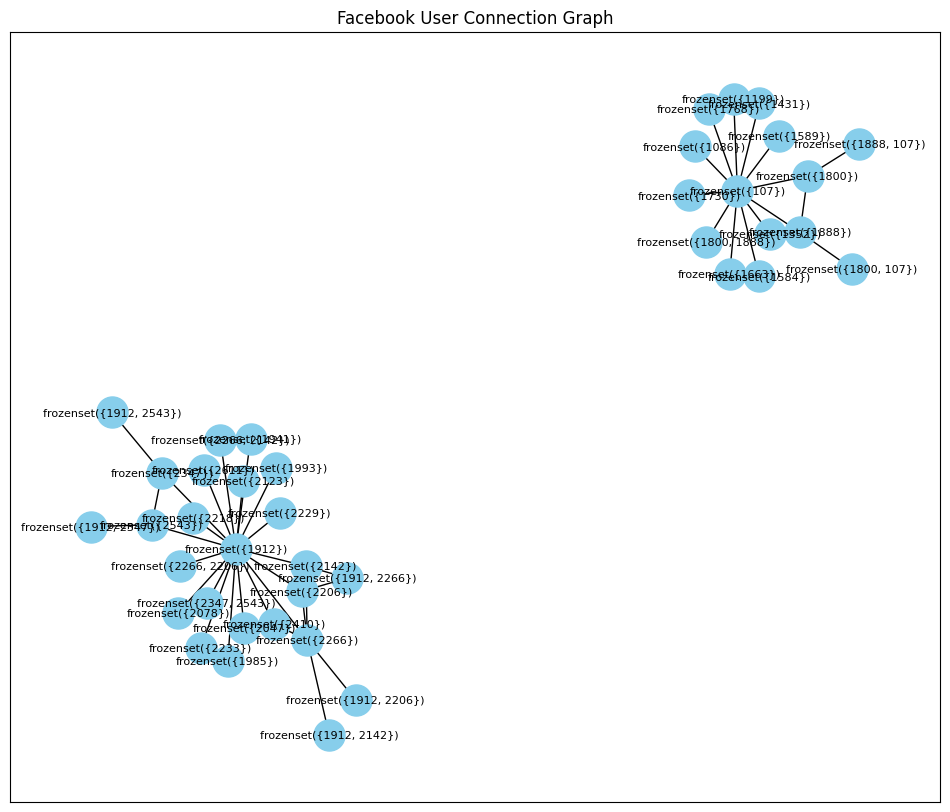

In [10]:
# 可视化结果
fig, ax = plt.subplots(figsize=(12, 10))
GA = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents')
nx.draw_networkx(GA, ax=ax, with_labels=True, node_color='skyblue', node_size=500, font_size=8)
plt.title('Facebook User Connection Graph')
plt.show()

- 同时，我们将度中心性最高的十个用户可视化，可以发现度中心性高的用户在上述图中出现的频率也高。这些用户与其他用户的关联更为紧密，影响更大（用户领袖）。

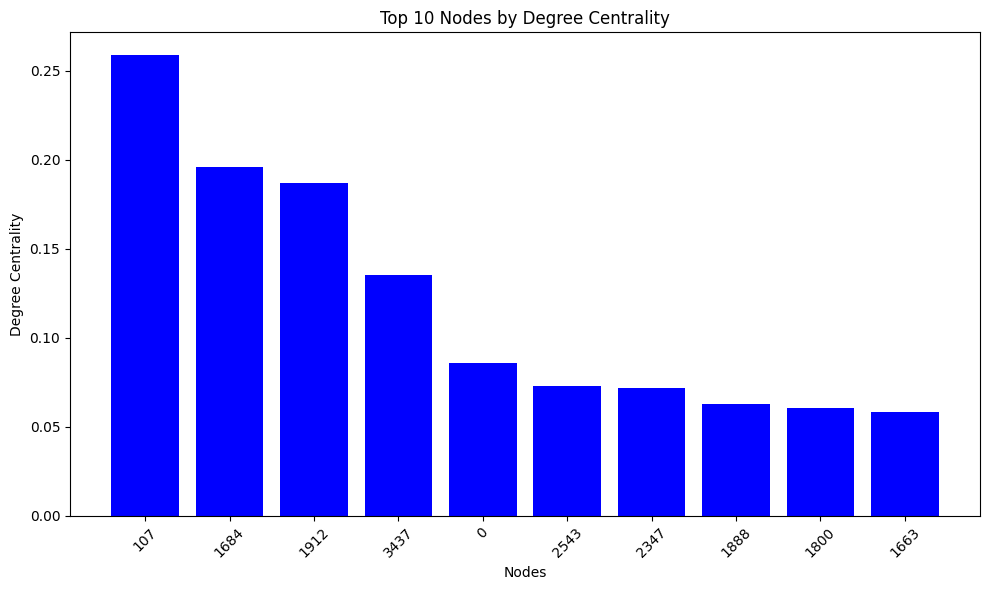

In [17]:
Degree_Centrality = nx.centrality.degree_centrality(network)
top_10_degree_centrality = sorted(Degree_Centrality.items(), key=lambda item: item[1], reverse=True)[:10]
nodes = [item[0] for item in top_10_degree_centrality]
centralities = [item[1] for item in top_10_degree_centrality]

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(range(len(nodes)), centralities, color='blue')
# 添加节点标签
plt.xticks(range(len(nodes)), nodes, rotation=45)
plt.xlabel('Nodes')
plt.ylabel('Degree Centrality')
plt.title('Top 10 Nodes by Degree Centrality')

plt.tight_layout()
plt.show()

- 对成环的用户进行频繁模式挖掘与关联规则生成，查找到社区中频繁出现的用户并找到其关联关系。该关联规则命名为社区模式。

In [33]:
te = TransactionEncoder()
te_ary = te.fit(circles).transform(circles)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.04, use_colnames=True)

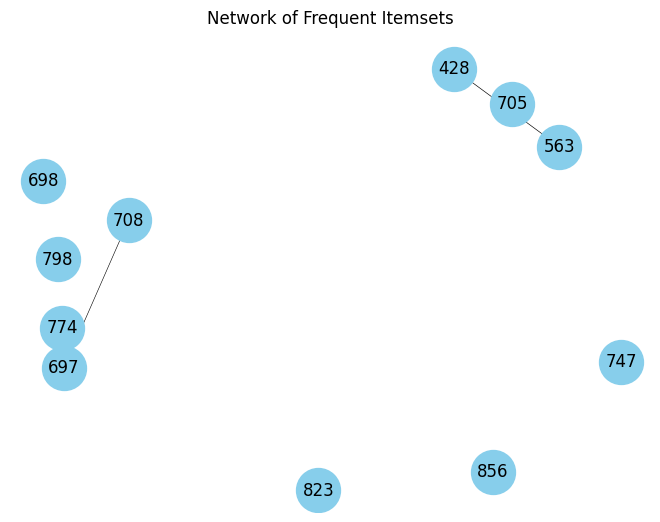

In [34]:
G = nx.Graph()
for index, row in frequent_itemsets.iterrows():
  # 为每个项集添加节点
  for item in row['itemsets']:
    G.add_node(item)
  # 为每对项集添加边，边的权重为支持度
  for (item1, item2) in combinations(row['itemsets'], 2):
    if G.has_edge(item1, item2):
      # 如果边已存在，增加权重
      G[item1][item2]['weight'] += row['support']
    else:
      # 添加新边
      G.add_edge(item1, item2, weight=row['support'])

# 根据边的权重调整边的宽度
edge_width = [G[u][v]['weight'] * 10 for u, v in G.edges()]

# 绘制图形
pos = nx.spring_layout(G, seed=42)  # 为了美观，使用spring布局
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='k', width=edge_width)
plt.title('Network of Frequent Itemsets')
plt.show()

- 实际整个网络中（使用facebook.txt）的社区如图所示。算法不同，效果有所不同。

社区数量 44


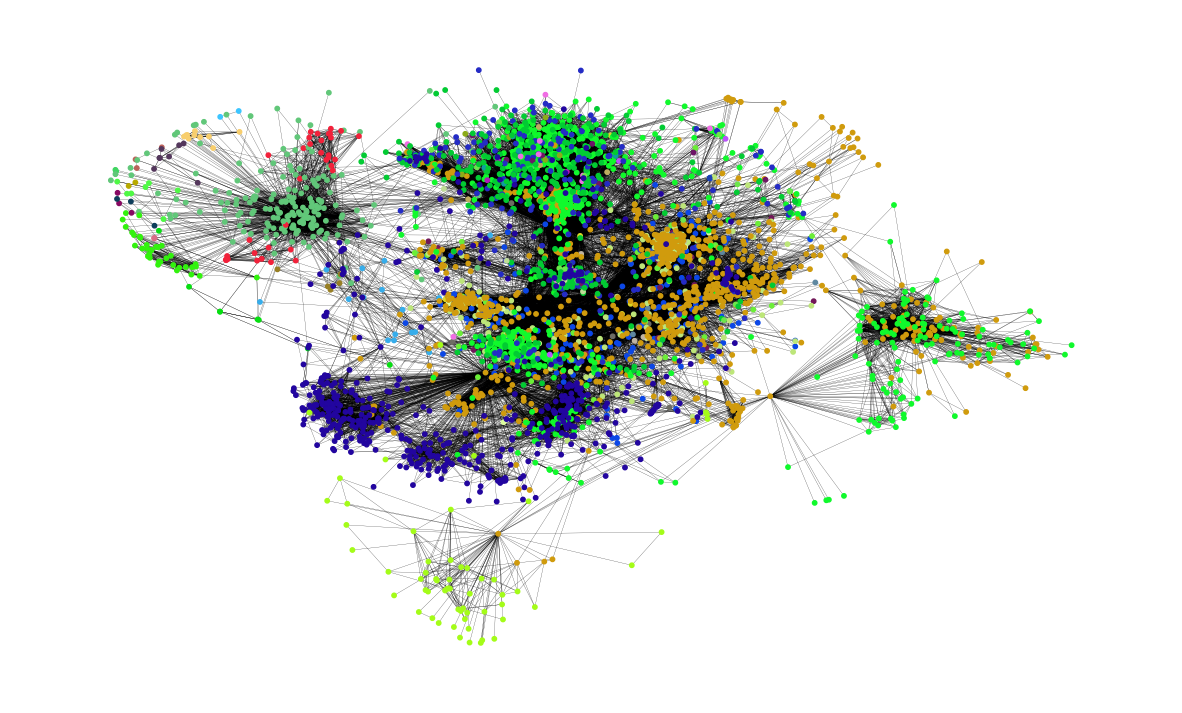

In [37]:
counter = 0
colors = ["" for x in range(Node_Num)]
for com in nx.community.label_propagation_communities(network):
    color = "#%06X" % randint(0, 0xFFFFFF)
    counter += 1
    for node in list(com):  # fill colors list with the particular color for the community nodes
        colors[node] = color
print("社区数量", counter)
# 社区示意图
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(network, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors)
plt.show()

# DBLP数据挖掘
## 数据获取与数据预处理
### 数据获取
从官网下载DBLP数据集。https://dblp.uni-trier.de/xml/ 手动下载较为缓慢，使用URL下载。

In [ ]:
import requests
import gzip
import shutil

# 定义要下载的文件 URL
url = "https://dblp.org/xml/dblp.xml.gz"
# 定义保存的文件名
output_file = "dblp.xml"

# 发送 GET 请求并保存响应
response = requests.get(url, stream=True)
if response.status_code == 200:
    # 将响应的内容写入文件
    with open(output_file + ".gz", 'wb') as f:
        f.write(response.content)
    print("Downloaded gzip file successfully.")
else:
    print("Failed to download gzip file.")

In [ ]:
!pwd

- 解压文件

In [ ]:
with gzip.open(output_file + ".gz", 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print("Extracted gzip file successfully.")

### 数据结构
- 我们知道数据集的结构如下所示,其中包含了每个文章的作者，题目，页码，发表年份等内容，所有属性如下所示:author、title、pages、year、volume、journal、number、url、ee。

### 数据预处理

- 原数据集中的数据格式并不适合根据作者属性进行频繁模式和关联规则挖掘。所以对数据集中的作者条目进行了预处理生成新的文件方便下一步的工作。




In [ ]:
from xml.sax import handler, make_parser
import codecs
import time
import numpy as np
import pandas as pd
# 包含作者的标签
paper_tag = ('article','inproceedings','proceedings','book','incollection',
             'phdthesis','mastersthesis','www')

class mHandler(handler.ContentHandler):
    def __init__(self,result):
        self.result = result
        self.flag = 0

    def startDocument(self):
        print('Document Start...')

    def endDocument(self):
        print('Document End...')

    def startElement(self, name, attrs):
        if name == 'author':
            self.flag = 1

    def endElement(self, name):
        if name == 'author':
            self.result.write(',')
            self.flag = 0
        if (name in paper_tag) :
            self.result.write('\r\n')

    def characters(self, chrs):
        if self.flag:
            self.result.write(chrs)

def parserDblpXml(source,result):
    handler = mHandler(result)
    parser = make_parser()
    parser.setContentHandler(handler)

    parser.parse(source)

In [ ]:
source = codecs.open('./dblp.xml','r','utf-8')
result = codecs.open('./authors.txt','w','utf-8')
parserDblpXml(source,result)
result.close()
source.close()

## 频繁模式挖掘
- 挖掘频繁模式，我们使用mlxtend中的Apriori包实现频繁模式挖掘，以图找到发布文章的共同作者（我们将这个模型命名为作者合作模式）。在进行频繁模式挖掘之前，我们需要先将数据采用独热编码进行处理。

In [ ]:
source = codecs.open('./authors.txt','r','utf-8')
result = codecs.open('./authors_one_hot.txt','w','utf-8')
index = codecs.open('./authors_index.txt','w','utf-8')
index_dic = {}   #字典记录one-hot编码与作者名字的对应关系
id = 0

for line in source:
    name_list = line.split(',')
    for name in name_list:
        if not (name == '\r\n'):
            if name in index_dic:
                index_dic[name][1] +=1  #计数
            else:
                index_dic[name] = [id,1]
                index.write(name + u'\r\n')
                id += 1
            # authors_encoded.txt
            result.write(str(index_dic[name][0]) + u',')
    result.write('\r\n')

source.close()
result.close()
index.close()

- 计算每个作者的support，进一步得到每个support下的作者数量并且将其可视化。可以发现，数量随着支持度的上升而下降。这也是符合客观规律的，高支持度的人数总是相对稀少。

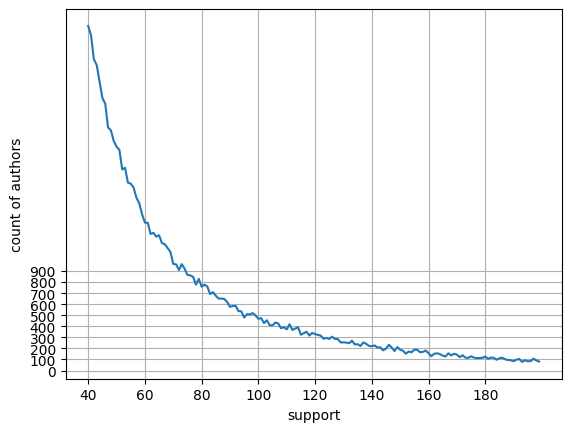

In [ ]:
import matplotlib.pyplot as plt
data = codecs.open('./authors_one_hot.txt','r','utf-8')
word_counts = {}  # 记录每个作者出现的次数
maxCounts = 0

for line in data:
    line = line.split(',')
    for word in line[0:-1]:
        word_counts[word] = word_counts.get(word,0) + 1
        if word_counts[word] > maxCounts:
            maxCounts = word_counts[word]
            maxKey = word

xMax = maxCounts
data.close()

#key->support,value=>author_count
bins = {}
for k,v in word_counts.items():
    bins[v] = bins.get(v,0) + 1

y = []
for i in range(40,200):
    y.append(bins.get(i,0))

plt.plot(y,'-');
plt.grid()
plt.yticks(range(0,1000,100))
plt.xticks(range(0,160,20),range(40,200,20))
plt.xlabel('support')
plt.ylabel('count of authors')
plt.show()

- 我们使用Mlxtend包里的Apriori算法进行了频繁模式的挖掘，因为数据集比较大，所以我们只使用前30000条数据集进行挖掘。部分准备工作如下，如参数设置，函数定义，独热编码生成。

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
dataLen=30000
minSup=10
min_con=0.5
def loadData(inFile):
    dataSet = []
    for line in inFile:
        line = line.strip().split(',')
        dataLine = [int(word) for word in line if word.isdigit()]
        dataSet.append(dataLine)
    return dataSet


In [ ]:
from scipy import sparse
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
with open('./authors_one_hot.txt', 'r') as f:
    f_lines = list(line for line in (l.strip()
            for l in f) if line)  # 去除空行
    dataSet = loadData(f_lines)
data = dataSet[0:dataLen]
#转化为One-Hot编码
te = TransactionEncoder()
te_ary = te.fit(data).transform(data, sparse=True)
sparse_matrix = sparse.csr_matrix(te_ary)
sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=te.columns_)
te_len = te_ary.shape[0]


In [ ]:
# 生成频繁项集
frequent_itemsets = apriori(sparse_df, min_support=minSup/te_len, use_colnames=True)
# 按照support列选择前10个
top_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
print(top_frequent_itemsets)

      support       itemsets
119  0.003000         (3729)
148  0.002833         (6674)
233  0.002633        (14295)
6    0.002300          (860)
345  0.002300  (3729, 14295)
147  0.002200         (6673)
18   0.002167          (890)
329  0.001867        (43923)
59   0.001533         (1673)
11   0.001367          (870)


#### 绘制频繁项集的条形图（仅显示最高频率的十个项集）

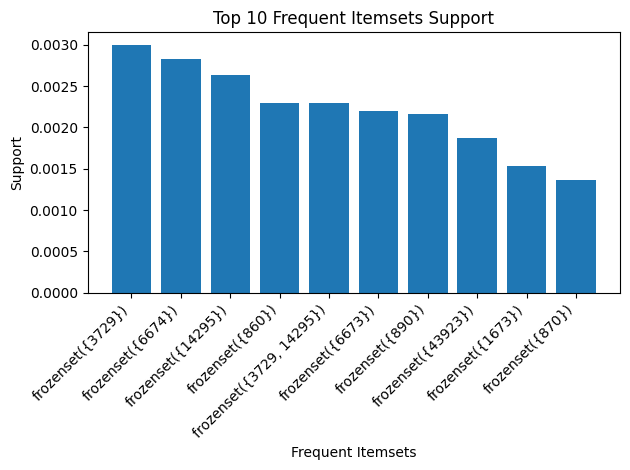

In [ ]:
top_10_frequent_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.bar(range(len(top_10_frequent_itemsets)), top_10_frequent_itemsets['support'])
plt.xticks(range(len(top_10_frequent_itemsets)), top_10_frequent_itemsets['itemsets'], rotation=45, ha='right')
plt.xlabel('Frequent Itemsets')
plt.ylabel('Support')
plt.title('Top 10 Frequent Itemsets Support')
plt.tight_layout()
plt.show()

In [ ]:
with open('./authors_index.txt','r') as authorsIndex:
    i = 0
    authorsDic = {}
    for name in authorsIndex:
        name = name.strip()
        authorsDic[i] = name
        i = i+1

rules = association_rules(frequent_itemsets, min_threshold=min_con)
ant_author = []
con_author = []

for index, row in rules.iterrows():
    a_list = []
    c_list = []

    antecedents = row['antecedents']
    consequents = row['consequents']
    for a in antecedents:
        authorA = authorsDic.get(int(a), '0')
        a_list.append(authorA)
    ant_author.append(a_list)

    for c in consequents:
        authorC = authorsDic.get(int(c), '0')
        c_list.append(authorC)
    con_author.append(c_list)
rules['ant_author'] = ant_author
rules['con_author'] = con_author
print(rules)

       antecedents     consequents  antecedent support  consequent support  \
0             (36)            (37)            0.000333            0.000400   
1             (37)            (36)            0.000400            0.000333   
2            (864)           (968)            0.000900            0.000700   
3            (968)           (864)            0.000700            0.000900   
4            (933)           (934)            0.000733            0.000733   
..             ...             ...                 ...                 ...   
80  (31920, 31919)         (31921)            0.000400            0.000467   
81  (31921, 31919)         (31920)            0.000400            0.000400   
82         (31920)  (31921, 31919)            0.000400            0.000400   
83         (31921)  (31920, 31919)            0.000467            0.000400   
84         (31919)  (31920, 31921)            0.000400            0.000400   

     support  confidence         lift  leverage  conviction  zh

- 将频繁模式挖掘结果保存。

In [ ]:
rules.to_csv('./dblp_result_' + str(dataLen) + '_' + str(minSup) + '_' + str(min_con) + '.csv', index=False)

### 关联规则支持度和置信度直方图

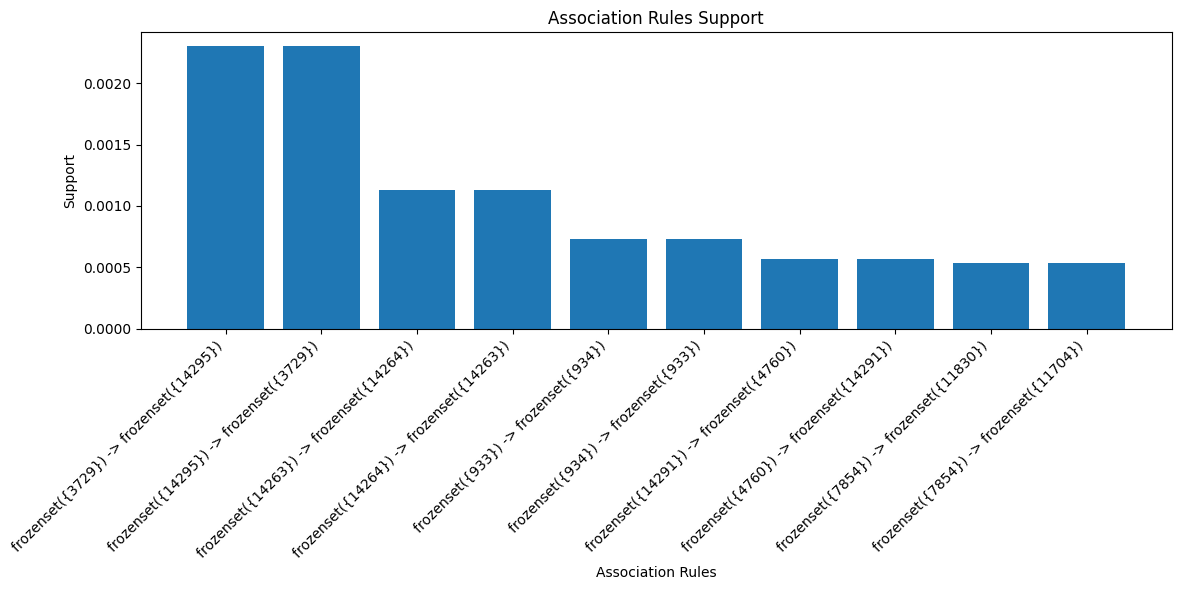

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


result_file = './dblp_result_' + str(dataLen) + '_' + str(minSup) + '_' + str(min_con) + '.csv'
df = pd.read_csv(result_file)

# 按support列排序并选择前10个
df = df.sort_values(by='support', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df['support'], tick_label=df['antecedents'].astype(str) + ' -> ' + df['consequents'].astype(str))
plt.xlabel('Association Rules')
plt.ylabel('Support')
plt.title('Association Rules Support')
plt.xticks(rotation=45, ha='right')  # 旋转X轴标签并向右对齐
plt.subplots_adjust(bottom=0.3, wspace=0.5)  # 调整子图布局，增加水平间距
plt.tight_layout()
plt.show()

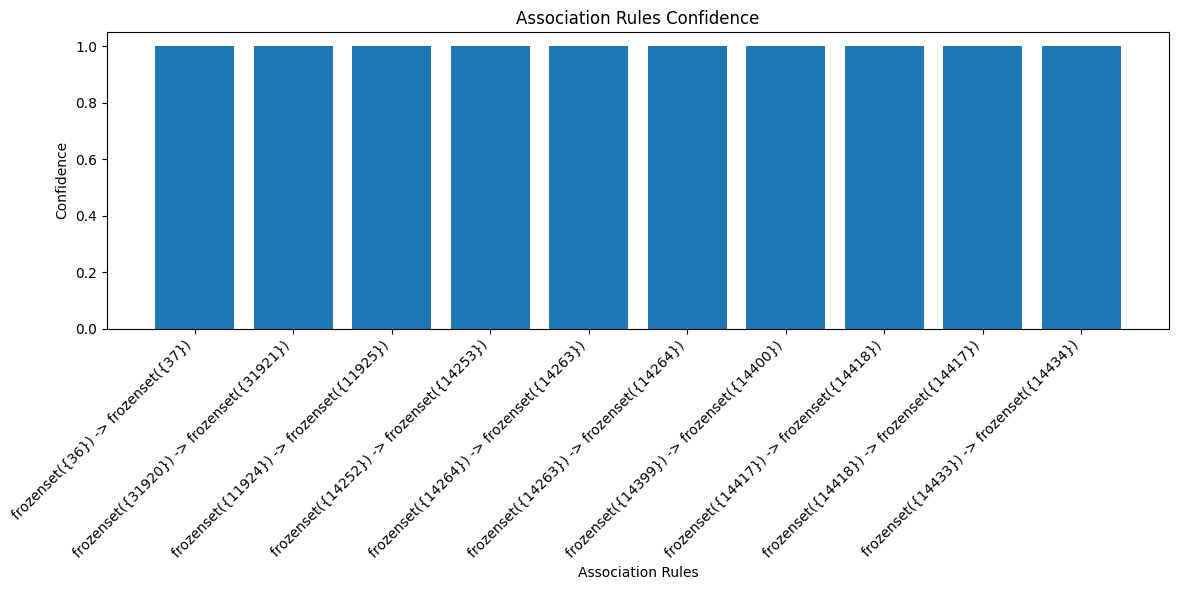

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


result_file = './dblp_result_' + str(dataLen) + '_' + str(minSup) + '_' + str(min_con) + '.csv'
df = pd.read_csv(result_file)

# 按confidence列排序并选择前10个
df = df.sort_values(by='confidence', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(df)), df['confidence'], tick_label=df['antecedents'].astype(str) + ' -> ' + df['consequents'].astype(str))
plt.xlabel('Association Rules')
plt.ylabel('Confidence')
plt.title('Association Rules Confidence')
plt.xticks(rotation=45, ha='right')  # 旋转X轴标签并向右对齐
plt.subplots_adjust(bottom=0.3, wspace=0.5)  # 调整子图布局，增加水平间距
plt.tight_layout()
plt.show()

#### 可视化关联规则的支持度和置信度散点图
- 综合分析直方图和散点图可以发现挖掘结果中的关联规则的支持度较低，置信度较高。低支持度意味着相对于整个数据集，该规则涵盖的情况较少。高置信度表明当前件出现时，后件很有可能也会出现。意味着尽管规则对于特定情况非常可靠（即前件发生时后件几乎总是发生），但这种情况在整个数据集中较为罕见。虽然这些规则出现的频率不高，但可能揭示出非常有价值的模式，特别是在诸如异常检测、稀有事件分析等场景中。由于这类规则的普遍性不高，它们可能不适合用于广泛的预测或推荐。

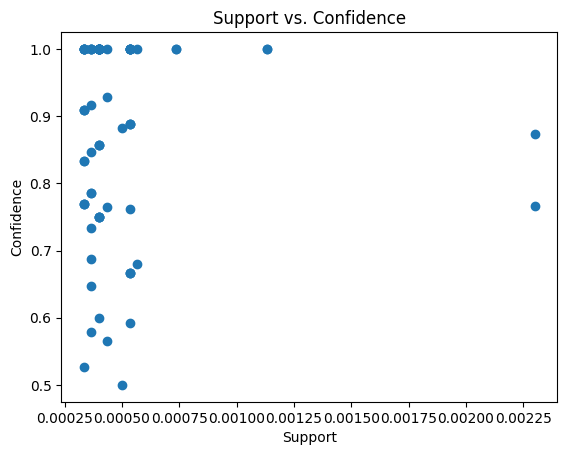

In [ ]:
plt.scatter(rules['support'], rules['confidence'])
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs. Confidence')
plt.show()